In [1]:
from tsdata.raw import available_data, load_data

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams["figure.figsize"] = (18, 8)
pd.set_option('display.max_columns', 500)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st

from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings('ignore')

# Import

In [2]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def plotSeries(data, legend='', title=''):
    ### There is a convention in python to use snake_case for function/method naming (CleanCoding)
    ### Here and below
    plt.figure(figsize=(20, 7))
    plt.plot(data, '-d', color='navy', markersize=3)
    plt.legend([legend], loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title(title)


def plotDecomposition(decomposition):
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    resid = decomposition.resid.dropna()

    plt.subplots(3, 1, figsize=(20, 21))

    plt.subplot(3, 1, 1)
    plt.plot(trend, color='navy', markersize=3, label='trend')
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title("Trend")

    plt.subplot(3, 1, 2)
    plt.plot(seasonal,
             '-gd', markersize=3, label='seasonal')
    plt.plot([seasonal.index[0], seasonal.index[-1]],
             seasonal.mean()*np.array([1, 1]), '--k',
             label=f"mean = {seasonal.mean():.3g}")
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title(
        f"Seasonal : range={(seasonal.max() - seasonal.min()):.3g}")

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid, '-o', color='maroon',
             markersize=3,  label='residuals')
    plt.plot([resid.index[0], resid.index[-1]],
             resid.mean()*np.array([1, 1]), '--k',
             label=f"mean = {resid.mean():.3g}")
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    plt.show()


def plotACF(data, decomposition, lags=50):
    trend = decomposition.trend.dronpna()
    seasonal = decomposition.seasonal.dronpna()
    resid = decomposition.resid.dropna()

    fig, axes = plt.subplots(4, 1, figsize=(15, 4*6))

    plot_acf(
        data,
        lags=lags,
        vlines_kwargs={'color': 'b'},
        markerfacecolor='b',
        markeredgecolor='b',
        title='Autocorrelation of target'
    )
    plot_acf(
        trend,
        lags=lags,
        vlines_kwargs={'color': 'navy'},
        markerfacecolor='navy',
        markeredgecolor='navy',
        title='Autocorrelation of trend'
    )
    plot_acf(
        seasonal,
        lags=lags,
        vlines_kwargs={'color': 'g'},
        markerfacecolor='g',
        markeredgecolor='g',
        title='Autocorrelation of seasonal'
    )

    plot_acf(
        resid,
        lags=lags,
        vlines_kwargs={'color': 'maroon'},
        markerfacecolor='maroon',
        markeredgecolor='maroon',
        title='Autocorrelation of residuals'
    )

    plt.show()


def plotPACF(data, decomposition, lags=36):
    trend = decomposition.trend.dronpna()
    seasonal = decomposition.seasonal.dronpna()
    resid = decomposition.resid.dropna()

    plot_acf(
        dataStat,
        lags=lags,
        vlines_kwargs={'color': 'b'},
        markerfacecolor='b', markeredgecolor='b',
        title='Autocorrelation of target'
    )

    plot_pacf(
        trend.dropna(),
        lags=lags,
        vlines_kwargs={'color': 'navy'},
        markerfacecolor='navy',
        markeredgecolor='navy',
        title='Partial autocorrelation of trend'
    )

    try:
        plot_pacf(
            seasonal,
            lags=lags,
            vlines_kwargs={'color': 'g'},
            markerfacecolor='g',
            markeredgecolor='g',
            title='Partial autocorrelation of seasonal'
        )
    except Exception as exc:
        print(exc)

    try:
        plot_pacf(
            resid,
            lags=lags,
            vlines_kwargs={'color': 'maroon'},
            markerfacecolor='maroon',
            markeredgecolor='maroon',
            title='Partial autocorrelation of residuals'
        )
    except Exception as exc:
        print(exc)

    plt.show()


def getResidAnalytics(resid):
    resid = resid.dropna()
    color = 'maroon'

    plt.subplots(1, 2, figsize=(24, 8))

    plt.subplot(1, 2, 1)
    plt.plot(resid, '-', color=color)
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    x_fit = np.linspace(resid.min(), resid.max(), 201)
    loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
    loc_norm, scale_norm = st.norm.fit(resid.dropna())
    # print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
    y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
    y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

    plt.subplot(1, 2, 2)
    sns.distplot(resid, color=color, bins=100, vertical=True,
                 label="distribution of residuals")
    plt.plot(y_fit_laplace, x_fit, '-b',
             label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
    plt.plot(y_fit_norm, x_fit, '-g',
             label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
    plt.legend()
    # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':', color='k')

    plt.show()

    ecdf_resid_instance = ECDF(resid.dropna())
    resid_arr = resid.dropna().sort_values().values
    ecdf_resid = ecdf_resid_instance(resid_arr)

    cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
    cdf_laplace = st.laplace.cdf(
        resid_arr, loc=loc_laplace, scale=scale_laplace)

    mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
    mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)

    plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
    plt.plot(resid_arr, cdf_norm, '-g',
             label=f"Normal approx : MAE = {mae_norm:.3g}")
    plt.plot(resid_arr, cdf_laplace, '-b',
             label=f"Laplace approx: MAE = {mae_laplace:.3g}")
    plt.legend()
    plt.title("CDF of decomposition residuals")
    plt.show()

    getStationary(resid)


def adffullerTest(data, alpha=0.05):
    print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====")
    result = adfuller(data.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < alpha:
        print("The process is" + color.BOLD + color.GREEN +
              " stationary " + color.END + "by ADF.\n")
    else:
        print("The process is" + color.BOLD + color.RED +
              " non-stationary " + color.END + "by ADF.\n")


def kpssTest(data, alpha=0.05):
    print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====')
    kpsstest = kpss(data.values, regression='c')
    print("KPSS Statistic = " + str(kpsstest[0]))
    print("p-value = " + str(kpsstest[1]))
    if kpsstest[1] < alpha:
        print("The process is" + color.BOLD + color.RED +
              " non-stationary " + color.END + "by KPSS.\n")
    else:
        print("The process is" + color.BOLD + color.GREEN +
              " stationary " + color.END + "by KPSS.\n")


def getStationary(data):
    ### misconfucsing naming - you do not get stationary, you CHECK it (CleanCoding)
    adffullerTest(data)
    kpssTest(data)


# 1. Produce forecasts for the following series

Produce forecasts for the following series using whichever of NAIVE(y), SNAIVE(y) or RW(y ~ drift()) is more appropriate in each case:

* Australian Population (global_economy)
* Bricks (aus_production)
* NSW Lambs (aus_livestock)
* Household wealth (hh_budget).
* Australian takeaway food turnover (aus_retail).

## 1. Australian Population (global_economy)

### Tidy (Data preparation)

In [3]:
global_economy = load_data('global_economy')
global_economy = global_economy[global_economy.Country == 'Australia']['Population'] 
_index = pd.date_range('1960-01-01', '2018-01-01', freq='Y')
global_economy.index = _index

### Visualise 

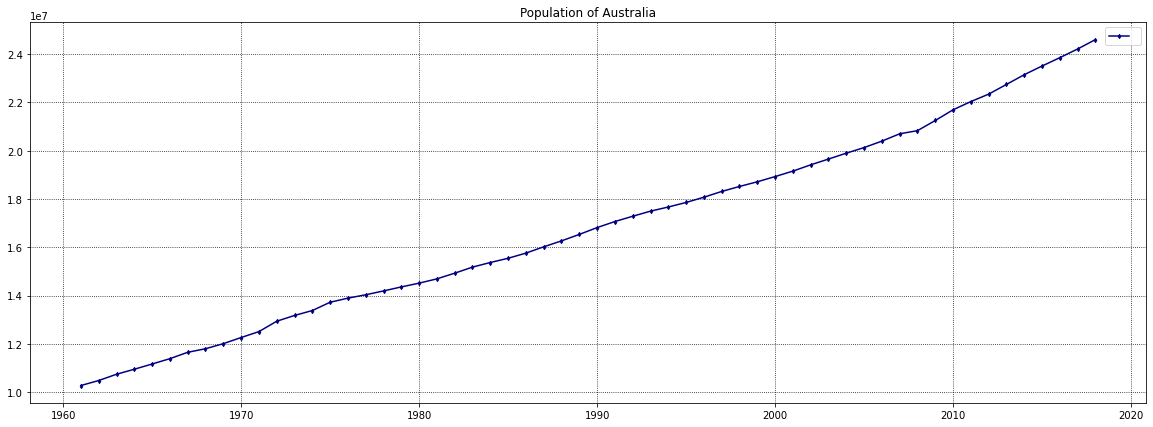

In [4]:
plotSeries(global_economy, title='Population of Australia')

### Specify

In [5]:
import statsmodels.formula.api as smf

In [6]:
global_economy_df = pd.DataFrame(global_economy).reset_index()
f = lambda x: x.year
global_economy_df['Date'] = global_economy_df['index'].map(f)
global_economy_df

,index,Population,Date
0,1960-12-31,10276477.0,1960
1,1961-12-31,10483000.0,1961
2,1962-12-31,10742000.0,1962
3,1963-12-31,10950000.0,1963
4,1964-12-31,11167000.0,1964
5,1965-12-31,11388000.0,1965
6,1966-12-31,11651000.0,1966
7,1967-12-31,11799000.0,1967
8,1968-12-31,12009000.0,1968
9,1969-12-31,12263000.0,1969


In [7]:
model = smf.ols('Population ~ Date', global_economy_df)

### Estimate

In [8]:
model = model.fit()

### Evaluate

In [9]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [10]:
def get_metrics(y_true, y_pred, model=''):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    df = pd.DataFrame({'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'MAPE': [mape]}, index=[model])
    return df 

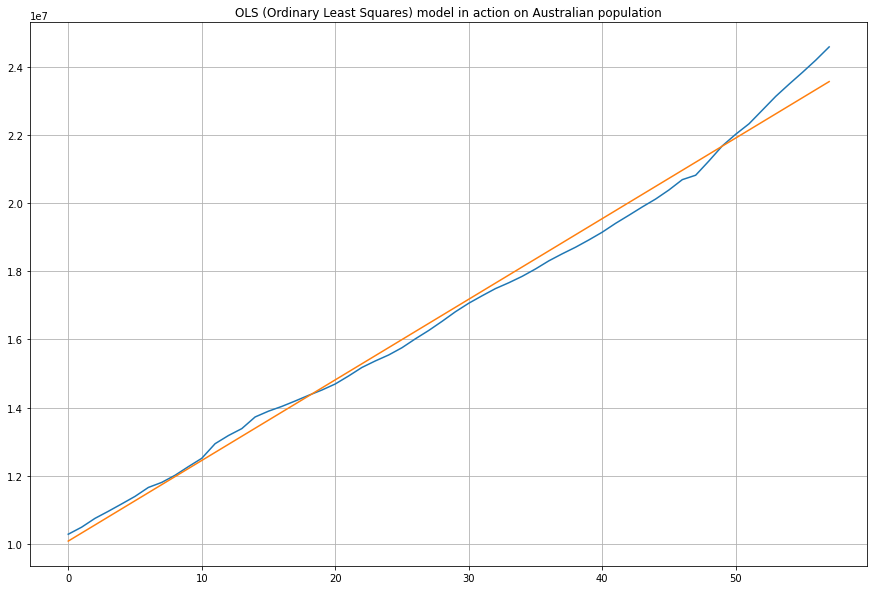

In [12]:
ny, nx = 1, 1
fig, ax = plt.subplots(ny, nx, figsize=(15, 10))

plt.subplot(ny, nx, 1)
ax.plot(global_economy_df['Population'])
pred = model.get_prediction(global_economy_df).summary_frame()['mean']
ax.plot(global_economy_df.index, pred)
ax.title.set_text('OLS (Ordinary Least Squares) model in action on Australian population')
ax.grid()
### It is the best practice to label lines and show them in legend

In [13]:
### What is the reason to drop R^2 ?
### Why do we need both MSE and RMSE?
### Why for do we calculate MAE, RMSE, MAPE at once?

get_metrics(global_economy_df.Population.values, pred.values)
# get_metrics(global_economy_df.Population.values, pred.values, model="model 1")

,MAE,MSE,RMSE,MAPE
,256079.152633,1.024852e+11,320133.051246,0.014458


In [14]:
global_economy_df['Date'].max()

2017

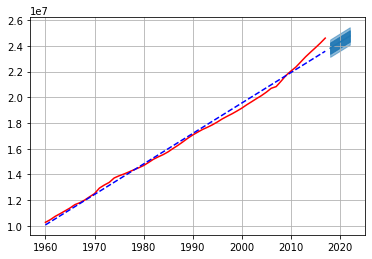

In [15]:
plt.plot(global_economy_df['Date'], global_economy_df['Population'], color='Red')

x = pd.DataFrame(dict(Date=np.arange(2018, 2023)))
pred_interval_95 = model.get_prediction(x).summary_frame()
pred_interval_80 = model.get_prediction(x).summary_frame(alpha=.2)
### Any time when you compare smth relevant to ground truth and prediction
### it will be better to plot both ground truth and prediction
plt.plot(global_economy_df['Date'], pred, "--b")

plt.plot(x.Date, pred_interval_80['mean'])

### Why for did you plot confidence corridor for the dates out of given data?
plt.fill_between(x.Date, pred_interval_95.obs_ci_lower, pred_interval_95.obs_ci_upper, color='C0', alpha=.5)
plt.fill_between(x.Date, pred_interval_80.obs_ci_lower, pred_interval_80.obs_ci_upper, color='C0', alpha=.9)
### plt.legend()
plt.grid()

It was just a litlle self-train task :) Here we can see that **prediction_interval** located in the same place as OLS predictions. The range of **prediction_interval** depends std of the TS

We have 4 simple methods for forecasting:
* Mean method
* Naive method
* SNaive method
* Drift method

I want to create Class which will get data(series) + do all predictions + create stats with all metrics + plot all predictions + plot prediction_interval 

    ### thumb up

## 2. Bricks (aus_production)

### Init functions

In [16]:
from utils import *

In [17]:
class SimpleTSModel:
    def __init__(self, y):
        self.y = y.asfreq(y.index.inferred_freq)
        self.freq = self.y.index.freq

    def forecast(self, periods=None):
        start = pd.to_datetime(self.y.index.max())
        end = pd.to_datetime(start + periods * (self.freq or 1))
        index = pd.date_range(start, end, freq=self.freq)
        return self.predict(start, end, index, periods)
    

class TSMean(SimpleTSModel):
    def predict(self, start, end, index, periods=None):
        m = self.y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out
    
    
class TSNaive(SimpleTSModel):
    def predict(self, start, end, index, periods=None):
        out = pd.Series(self.y.iloc[-1], index=index)
        return out

    
class TSNaiveSeasonal(SimpleTSModel):
    def __init__(self, y, lag):
        super().__init__(y)
        self.lag = lag
    
    def predict(self, start, end, index, periods=None):
        out = pd.Series(np.nan, index)
        for idx in range(0, periods + 1):
            out.iloc[idx] = self.y.loc[index[idx] - self.freq * int(self.lag * (np.floor((idx - 1)/self.lag) + 1))]
        out.iloc[0] = self.y.iloc[-1]
        return out

class TSDrift(SimpleTSModel):
    def predict(self, start, end, index, periods=None):
        out  = pd.Series(np.nan, index)
        y_last = self.y.iloc[-1]
        y_first = self.y.iloc[0]
        ts_range = len(self.y)
        out.iloc[0] = y_last
        for idx in range(1, periods + 1):
            out.iloc[idx] = y_last + idx * ((y_last - y_first) / (ts_range - 1))
        return out.copy()

### Tidy

In [18]:
aus_production = load_data('aus_production')[['Bricks']]
_index = pd.date_range('1956-01-01', '2010-07-01', freq ='Q')
aus_production.index = _index
aus_production = aus_production['Bricks']
aus_production

1956-03-31    189.0
1956-06-30    204.0
1956-09-30    208.0
1956-12-31    197.0
1957-03-31    187.0
              ...  
2009-06-30      NaN
2009-09-30      NaN
2009-12-31      NaN
2010-03-31      NaN
2010-06-30      NaN
Freq: Q-DEC, Name: Bricks, Length: 218, dtype: float64

In [20]:
print("Check all nans are sequantial and placed in the end:")

idx = aus_production[aus_production.isna() == True].index
aus_production[idx]

Check all nans are sequantial and placed in the end:


2005-09-30   NaN
2005-12-31   NaN
2006-03-31   NaN
2006-06-30   NaN
2006-09-30   NaN
2006-12-31   NaN
2007-03-31   NaN
2007-06-30   NaN
2007-09-30   NaN
2007-12-31   NaN
2008-03-31   NaN
2008-06-30   NaN
2008-09-30   NaN
2008-12-31   NaN
2009-03-31   NaN
2009-06-30   NaN
2009-09-30   NaN
2009-12-31   NaN
2010-03-31   NaN
2010-06-30   NaN
Freq: Q-DEC, Name: Bricks, dtype: float64

In [21]:
aus_production.dropna(inplace=True)

### Visualise

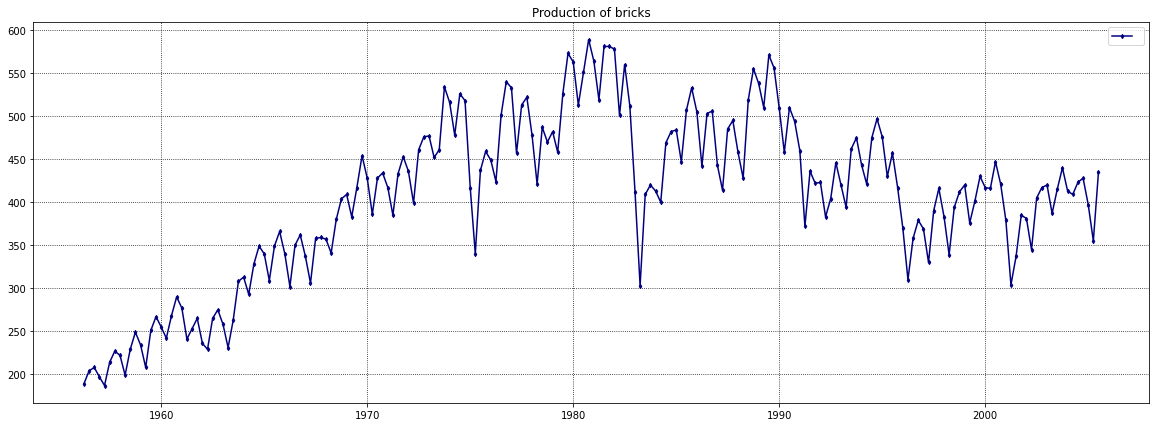

In [22]:
plotSeries(aus_production, title='Production of bricks')

### Specify

In [23]:
aus_production
# I want to predict next year
FORECAST_RANGE = 4

In [24]:
train_x = aus_production[:-FORECAST_RANGE]
train_y = aus_production[-FORECAST_RANGE-1:]

In [25]:
### Once

m = TSMean(train_x)
n = TSNaive(train_x)
s = TSNaiveSeasonal(train_x, 4)
dr = TSDrift(train_x)

In [26]:
df = aus_production
FORECAST_RANGE = 4


train_x = aus_production[:-FORECAST_RANGE]
train_y = aus_production[-FORECAST_RANGE-1:]


### Once

m = TSMean(train_x)
n = TSNaive(train_x)
s = TSNaiveSeasonal(train_x, 4)
dr = TSDrift(train_x)

### Estimate

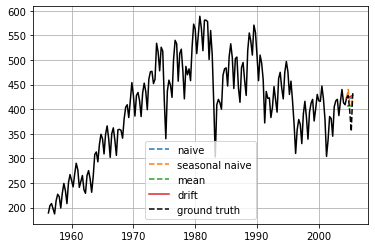

In [27]:
plt.plot(train_x, color='k')
plt.plot(n.forecast(periods=4), color='C0', linestyle = '--', label='naive')
plt.plot(s.forecast(periods=4), color='C1', linestyle = '--', label='seasonal naive')
plt.plot(m.forecast(periods=4), color='C2', linestyle = '--', label='mean')
plt.plot(dr.forecast(periods=4), color='C3', label='drift')
plt.plot(train_y, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

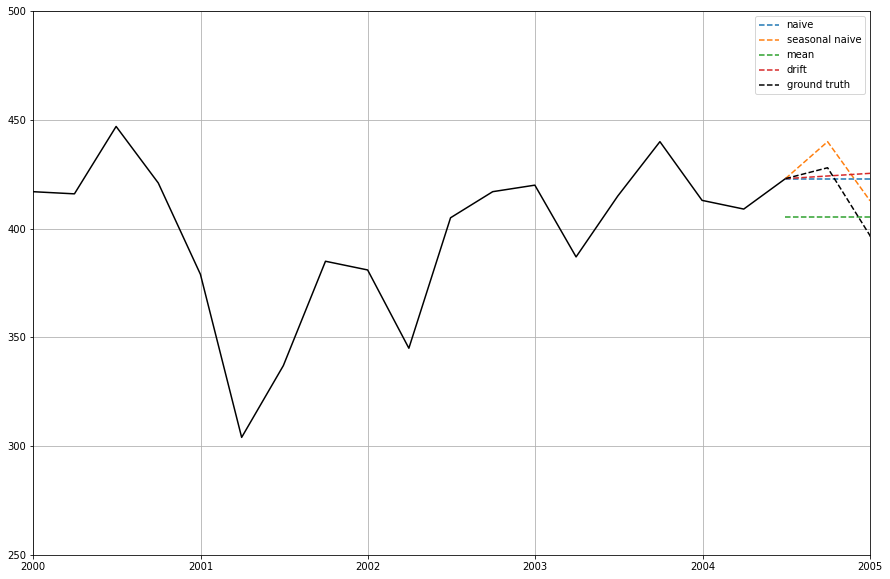

In [28]:
### We make plots to show results, please make them large enough
plt.subplots(1, 1, figsize=(15, 10))

ax = plt.subplot(1, 1, 1)
ax.set_xlim(pd.to_datetime('2000'), pd.to_datetime('2005'))
ax.set_ylim(250, 500)

ax.plot(train_x, color='k')
ax.plot(n.forecast(periods=4), color='C0', linestyle = '--', label='naive')
ax.plot(s.forecast(periods=4), color='C1', linestyle = '--', label='seasonal naive')
ax.plot(m.forecast(periods=4), color='C2', linestyle = '--', label='mean')
ax.plot(dr.forecast(periods=4), color='C3', linestyle = '--', label='drift')
ax.plot(train_y, color='k', linestyle = '--', label='ground truth')

plt.legend()
plt.grid()

In [29]:
models = [m, n, s, dr]

In [30]:
### Conclusions?

train_metrics = []
for model, name_model in zip(models, ['Mean', 'Naive', 'NaiveSeasonal', 'Drift']):
    metric_table = get_metrics(model.forecast(periods=4), train_y, model=name_model)
    train_metrics.append(metric_table)
train_metrics = pd.concat(train_metrics)
train_metrics


### df.style.apply(highlight_max)

,MAE,MSE,RMSE,MAPE
Mean,25.693814,860.921060,29.341456,0.063358
Naive,22.200000,1093.800000,33.072647,0.052482
NaiveSeasonal,18.800000,692.000000,26.305893,0.045282
Drift,22.200000,1201.069736,34.656453,0.052073


***!!!!Следующие 3 задания пропущу, так как они однотипные!!!!***

    ### Неа :) Сделай пайплайн, который можно запускать на любом датасете только лишь указывая период

## 3. NSW Lambs (aus_livestock)

### Tidy

### Visualise

### Specify

### Estimate

## 4. Household wealth (hh_budget)

### Tidy

### Visualise

### Specify

### Estimate

## 5. Australian takeaway food turnover (aus_retail).

### Tidy

### Visualise

### Specify

### Estimate

# 2. Use the Facebook stock price (data set gafa_stock) to do the following:


* Produce a time plot of the series.
* Produce forecasts using the drift method and plot them.
* Show that the forecasts are identical to extending the line drawn between the first and last observations.
* Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?

## Tidy

In [35]:
gafa_stock = load_data('gafa_stock')
gafa_stock['Date_dt'] = pd.to_datetime(gafa_stock['Date'])
gafa_stock = gafa_stock[gafa_stock['Symbol'] == "FB"]
gafa_stock = gafa_stock[['Date_dt', 'Close']]
gafa_stock = gafa_stock.groupby(pd.Grouper(key='Date_dt', axis=0, freq='w')).sum()
_index = pd.date_range('2014-01-05', '2019-01-06', freq='W')
gafa_stock.index = _index
gafa_stock = gafa_stock['Close']
gafa_stock.head()

# переведем дневные данные в недельные, чтобы избавиться от выходных

2014-01-05    109.270000
2014-01-12    288.509999
2014-01-19    284.739998
2014-01-26    227.099998
2014-02-02    285.869999
Freq: W-SUN, Name: Close, dtype: float64

## Visualise

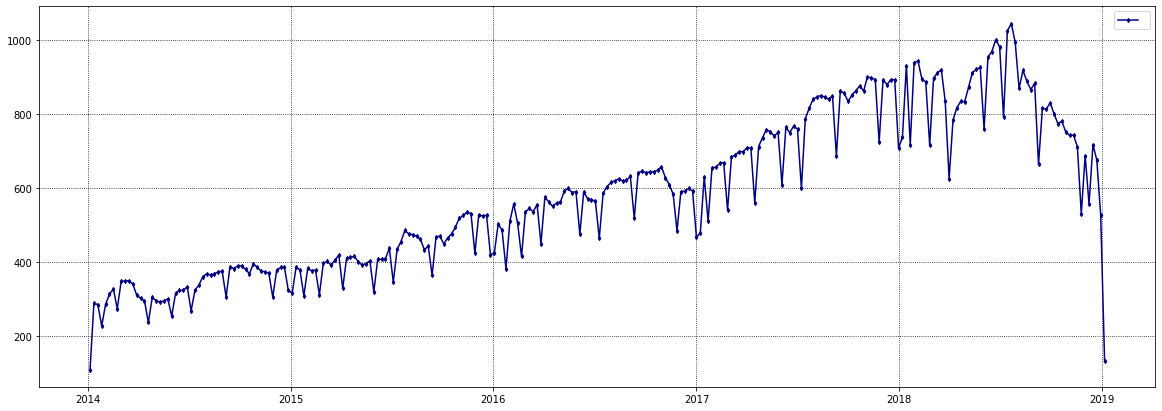

In [36]:
plotSeries(gafa_stock)

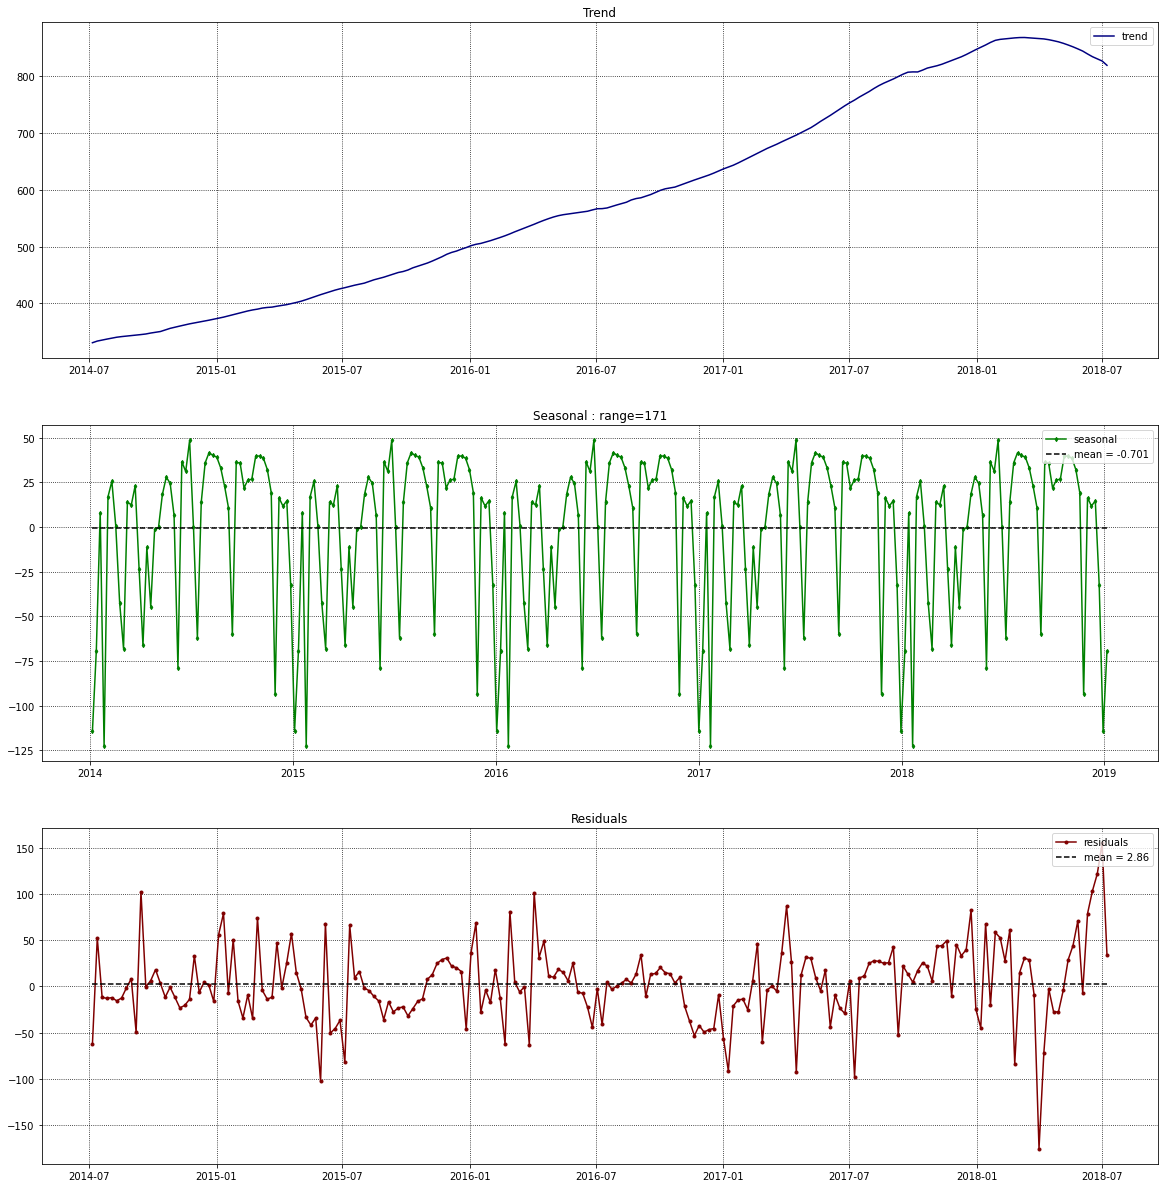

In [37]:
decompose = seasonal_decompose(gafa_stock, period=52)
plotDecomposition(decompose)

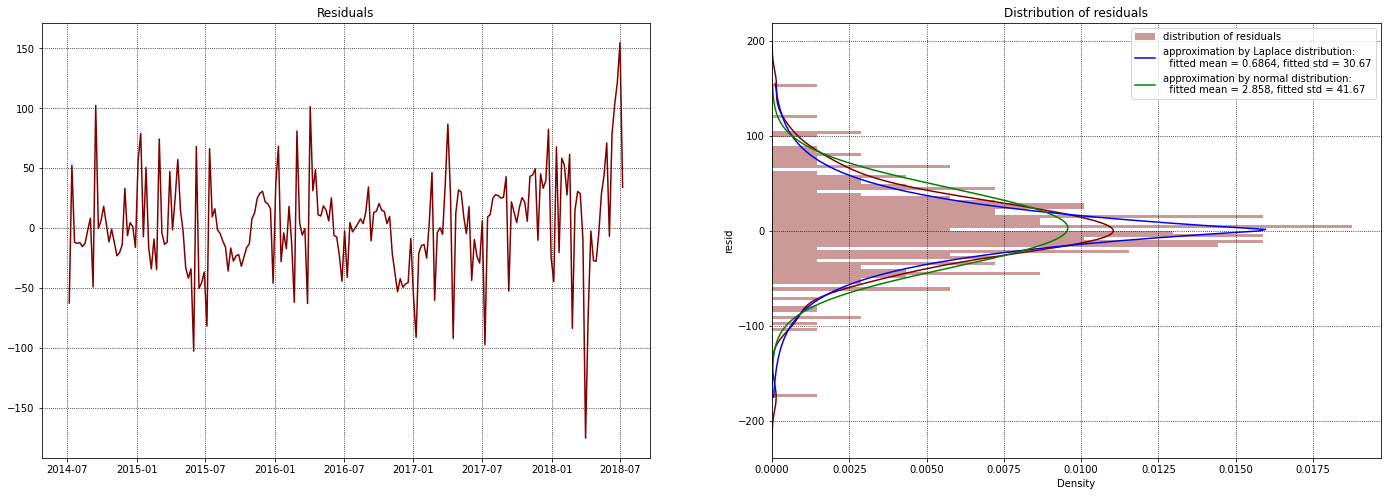

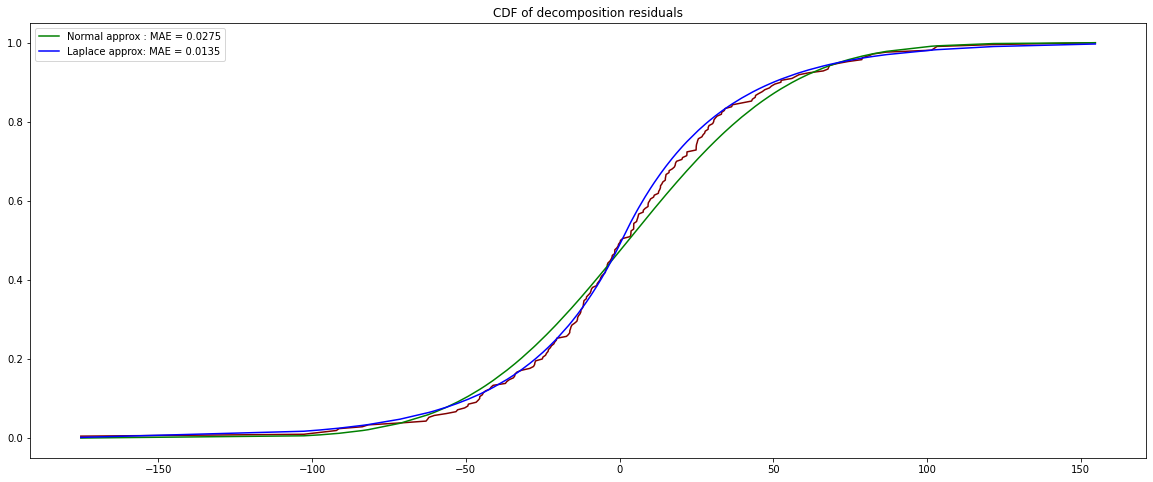

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -4.7933404952233
p-value: 5.600392360582834e-05
The process is stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.2605048448417737
p-value = 0.1
The process is stationary by KPSS.



In [38]:
getResidAnalytics(decompose.resid)

Период = 52 (в году 52 недели -.-)

## Specify

In [39]:
def get_train_x_y(df, forecast_range):
    return df[:-forecast_range], df[-forecast_range-1:]

In [40]:
FORECAST_RANGE = 5

train_x, train_y = get_train_x_y(gafa_stock, forecast_range=FORECAST_RANGE)

In [41]:
dr = TSDrift(train_x)

## Evaluate

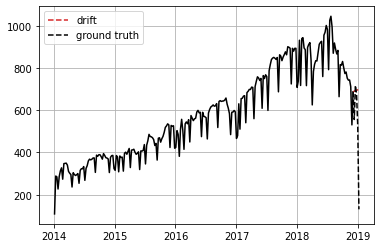

In [42]:
plt.plot(train_x, color='k')
plt.plot(dr.forecast(periods=FORECAST_RANGE),linestyle = '--', color='C3', label='drift')
plt.plot(train_y, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

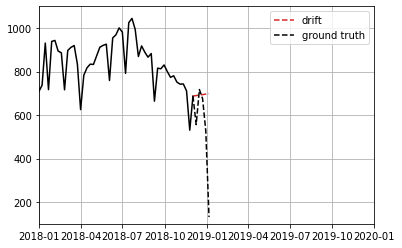

In [43]:
ax = plt.subplot(1, 1, 1)
ax.set_xlim(pd.to_datetime('2018'), pd.to_datetime('2020'))
ax.set_ylim(100, 1100)

ax.plot(train_x, color='k')
ax.plot(dr.forecast(periods=FORECAST_RANGE), color='C3', linestyle = '--', label='drift')
ax.plot(train_y, color='k', linestyle = '--', label='ground truth')

plt.legend()
plt.grid()

In [44]:
get_metrics(dr.forecast(periods=FORECAST_RANGE), train_y)

,MAE,MSE,RMSE,MAPE
,152.678802,61689.468979,248.373648,0.21915


## Specify - 2

In [45]:
dr2 = TSDrift(gafa_stock)

## Evaluate - 2

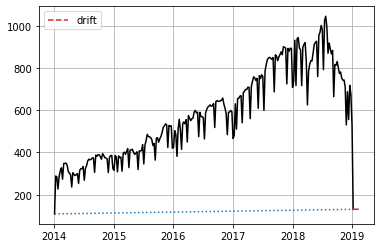

In [46]:
### Why did you do all the stuff below not for train subset?!


plt.plot(gafa_stock, color='k')
plt.plot(dr2.forecast(periods=FORECAST_RANGE),linestyle = '--', color='C3', label='drift')

x = gafa_stock.index
y = np.linspace(gafa_stock.iloc[0], gafa_stock.iloc[-1], len(x))
### Indeed you plotted the line BEFORE last point this way and the prediction ADTER last points
### Please prove that these lines are identical

plt.plot(x, y, linestyle=':')

plt.legend()
plt.grid()

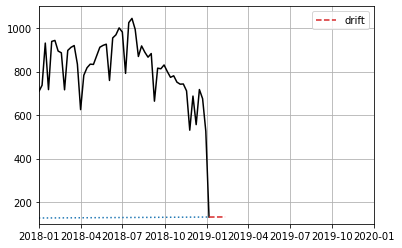

In [48]:
ax = plt.subplot(1, 1, 1)
x = gafa_stock.index
y = np.linspace(gafa_stock.iloc[0], gafa_stock.iloc[-1], len(x))

ax.plot(gafa_stock, color='k')
ax.plot(dr2.forecast(periods=FORECAST_RANGE),linestyle = '--', color='C3', label='drift')
ax.plot(x, y, linestyle=':')

ax.set_xlim(pd.to_datetime('2018'), pd.to_datetime('2020'))
ax.set_ylim(100, 1100)

ax.legend()
ax.grid()

***Show that the forecasts are identical to extending the line drawn between the first and last observations.***



In [49]:
m = TSMean(gafa_stock)
n = TSNaive(gafa_stock)
s = TSNaiveSeasonal(gafa_stock, 52)
dr = TSDrift(gafa_stock)

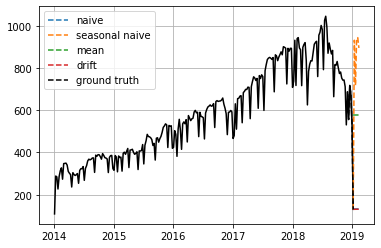

In [50]:
plt.plot(gafa_stock, color='k')
plt.plot(n.forecast(periods=FORECAST_RANGE), color='C0', linestyle = '--', label='naive')
plt.plot(s.forecast(periods=FORECAST_RANGE), color='C1', linestyle = '--', label='seasonal naive')
plt.plot(m.forecast(periods=FORECAST_RANGE), color='C2', linestyle = '--', label='mean')
plt.plot(dr.forecast(periods=FORECAST_RANGE), color='C3', linestyle = '--', label='drift')
plt.plot(train_y, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

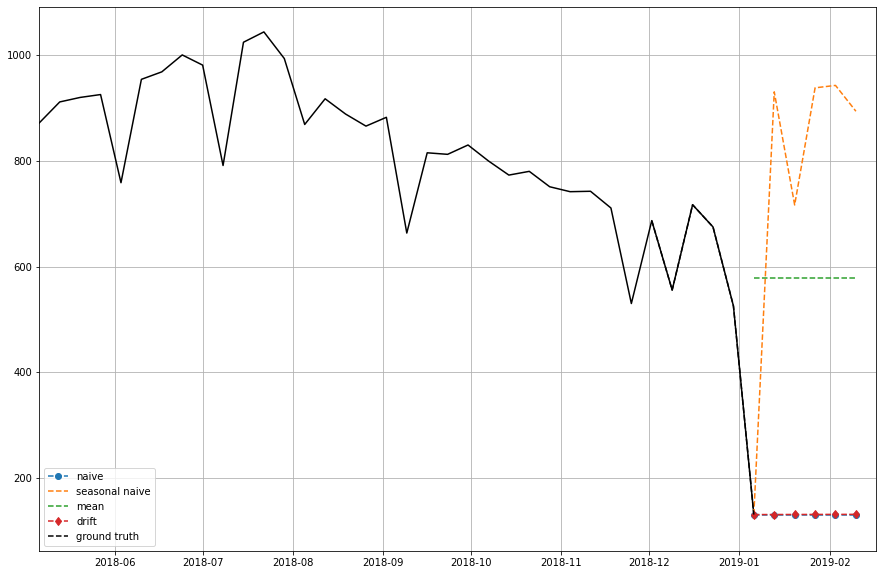

In [53]:
### The plot above seems to be insufficient. I do not observe details of forecast.

t_min = gafa_stock.index[-36]
t_max = n.forecast(periods=FORECAST_RANGE).index[-1] + (n.forecast(periods=FORECAST_RANGE).index[-1] - n.forecast(periods=FORECAST_RANGE).index[-2])


plt.subplots(1, 1, figsize=(15, 10))
plt.plot(gafa_stock, color='k')
plt.plot(n.forecast(periods=FORECAST_RANGE), 'o', color='C0', linestyle = '--', label='naive')
plt.plot(s.forecast(periods=FORECAST_RANGE), color='C1', linestyle = '--', label='seasonal naive')
plt.plot(m.forecast(periods=FORECAST_RANGE), color='C2', linestyle = '--', label='mean')
plt.plot(dr.forecast(periods=FORECAST_RANGE), 'd', color='C3', linestyle = '--', label='drift')
plt.plot(train_y, color='k', linestyle = '--' , label='ground truth')
plt.xlim(t_min, t_max)
plt.legend()
plt.grid()

***Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?***

Думаю в данном случае лучше подходит naive метод, потому что сложно представить, чтобы цена на акции моментально поднялась обратно :) 

    ### At first, no one can compare the forecast with ground truth. And calculate metrics (a hint).

# 3. Apply a seasonal naïve method

Apply a seasonal naïve method to the quarterly Australian beer production data from 1992. Check if the residuals look like white noise, and plot the forecasts.

# Tidy

In [54]:
aus_beer = load_data('aus_production')[['Beer']]
_index = pd.date_range('1956-01-01', '2010-07-01', freq ='Q')
aus_beer.index = _index
aus_beer = aus_beer['Beer']
aus_beer

1956-03-31    284
1956-06-30    213
1956-09-30    227
1956-12-31    308
1957-03-31    262
             ... 
2009-06-30    398
2009-09-30    419
2009-12-31    488
2010-03-31    414
2010-06-30    374
Freq: Q-DEC, Name: Beer, Length: 218, dtype: int64

## Visualise

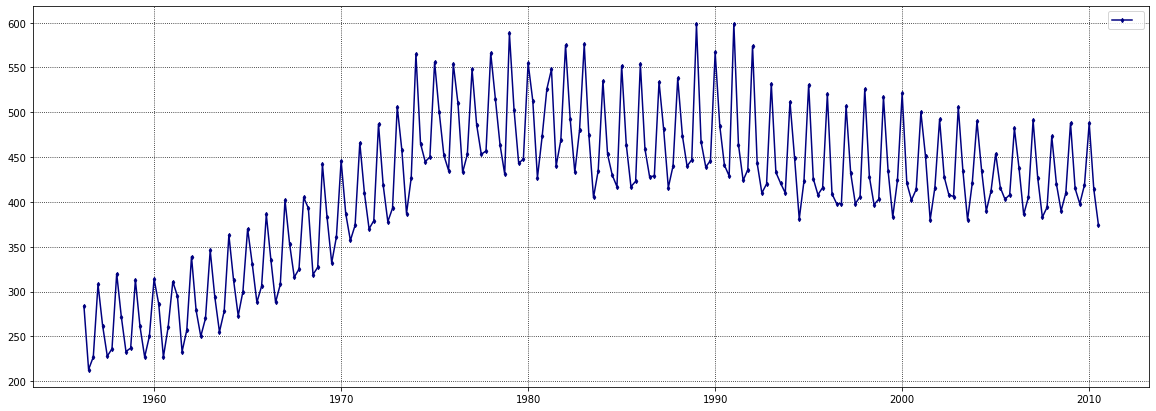

In [55]:
plotSeries(aus_beer)

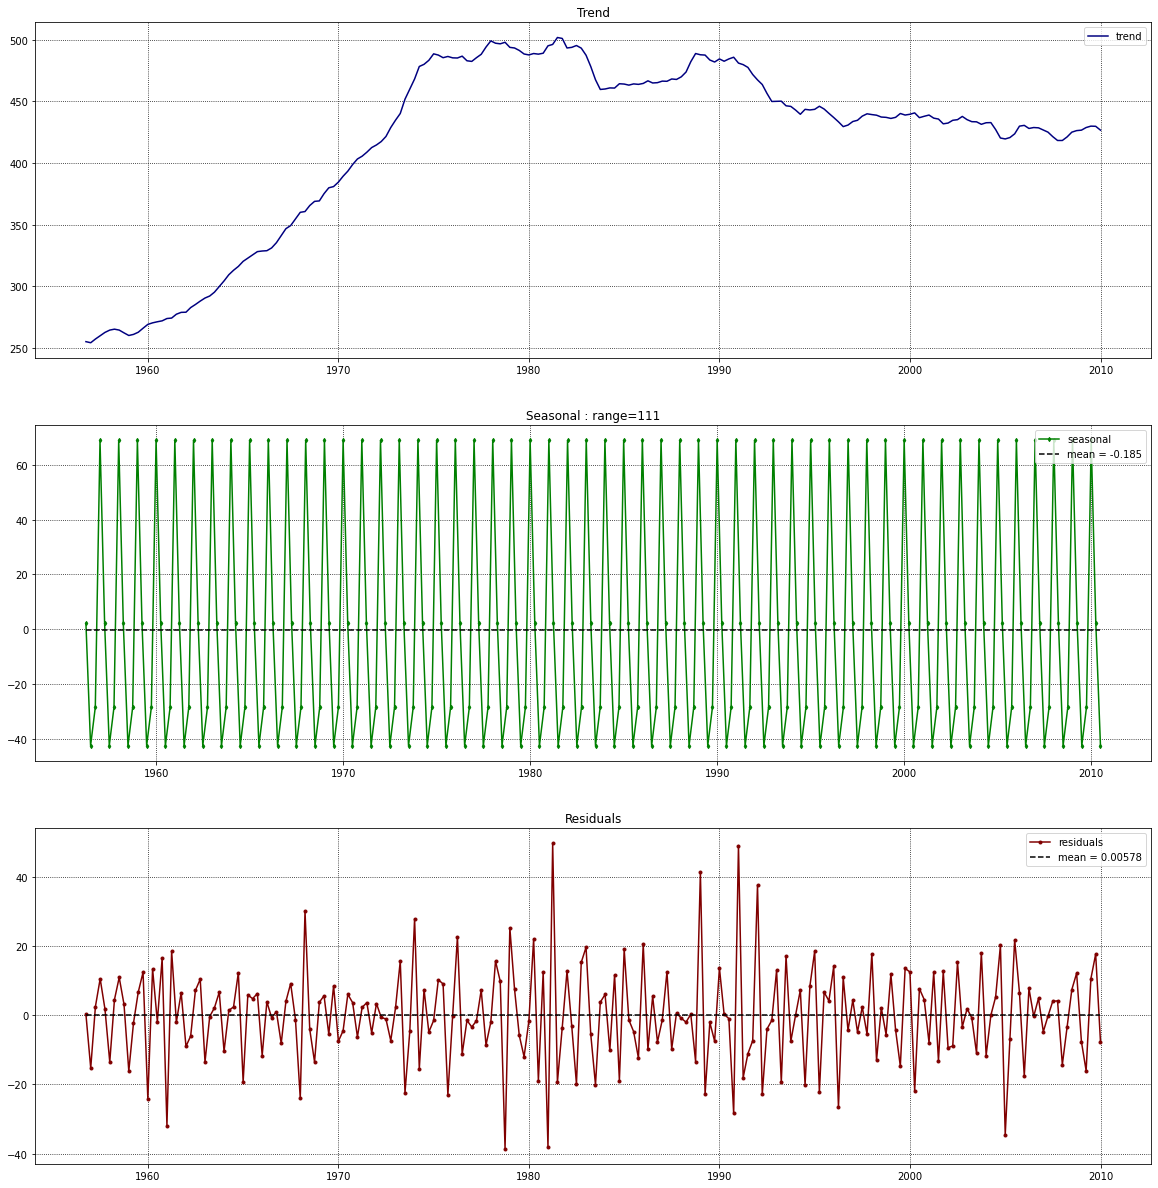

In [56]:
decompose = seasonal_decompose(aus_beer, period=4)
plotDecomposition(decompose)

## Specify

In [57]:
train_x = aus_beer[aus_beer.index < '1992']
train_y = aus_beer[aus_beer.index >= '1992']

In [58]:
FORECAST_RANGE = len(train_y)

In [59]:
sn = TSNaiveSeasonal(train_x, lag=4)

## Estimate

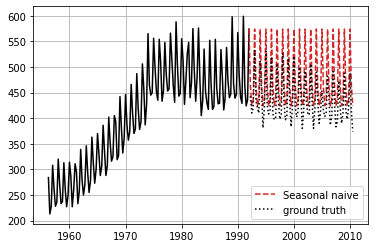

In [60]:
plt.plot(train_x, color='k')
plt.plot(sn.forecast(periods=FORECAST_RANGE),linestyle = '--', color='C3', label='Seasonal naive')
plt.plot(train_y, color='k', linestyle = ':' , label='ground truth')

plt.legend()
plt.grid()

In [61]:
get_metrics(dr.forecast(periods=FORECAST_RANGE).iloc[1:], train_y)

,MAE,MSE,RMSE,MAPE
,299.288461,91444.150599,302.397339,2.231012


In [62]:
resid = pd.Series(dr.forecast(periods=FORECAST_RANGE).iloc[1:].values - train_y.values)

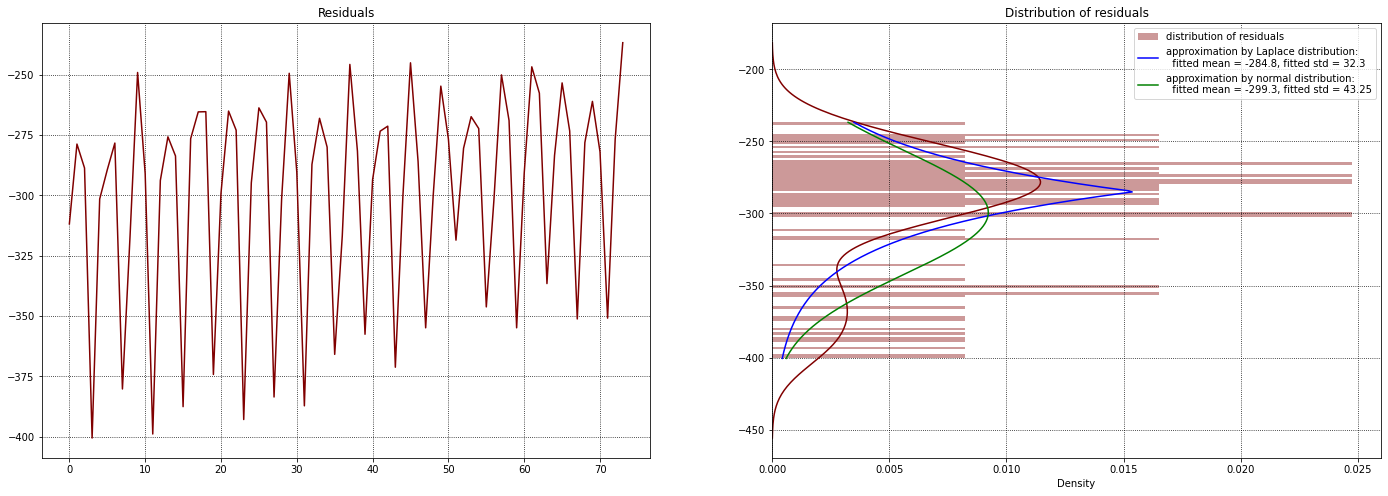

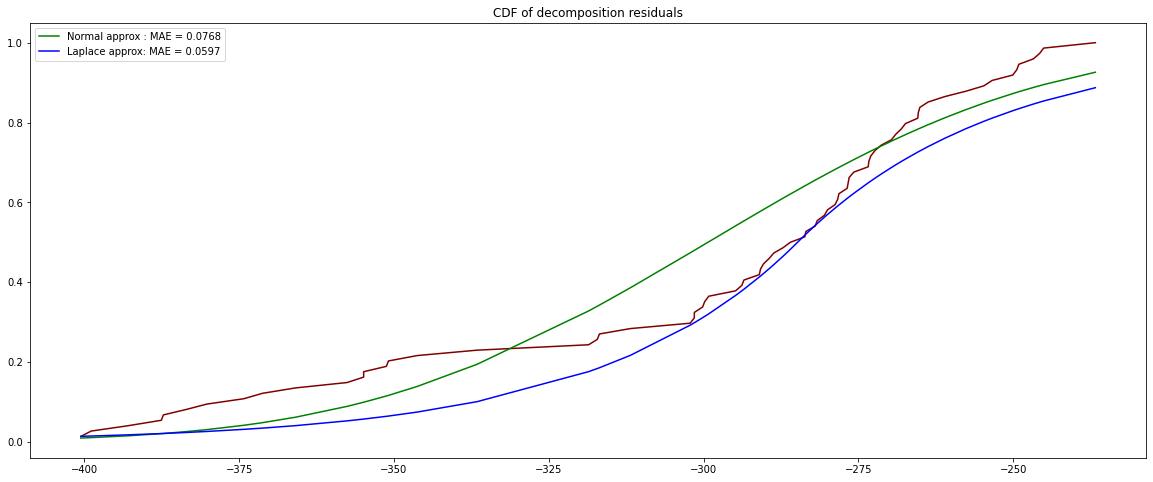

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -1.0410877556342881
p-value: 0.7379851853884984
The process is non-stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.5086573660899517
p-value = 0.039716809439200064
The process is non-stationary by KPSS.



In [63]:
getResidAnalytics(resid)

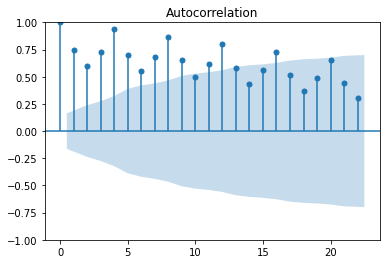

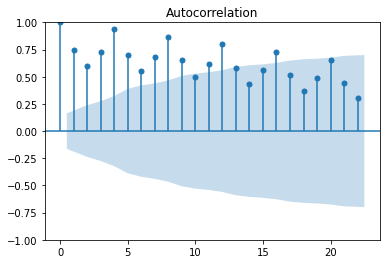

In [65]:
plot_acf(train_x)

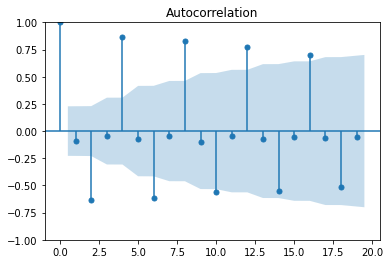

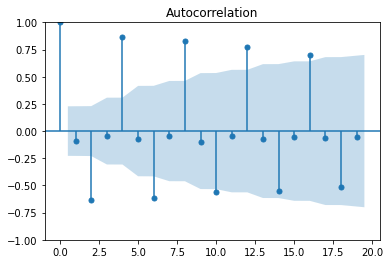

In [64]:
plot_acf(resid)

Остатки ужасные, в них остался тренд, поэтому naive_seasonal здесь будет давай плохие предсказания

    ### You checked the stationarity and found out that the series is not stationary. Then you analyze ACF for non-statiionary series... Why? What should you observe if you analyze trend?

# 4. Repeat the previous exercise

Repeat the previous exercise using the Australian Exports series from global_economy and the Bricks series from aus_production. Use whichever of NAIVE() or SNAIVE() is more appropriate in each case.



## Tidy

In [66]:
global_economy = load_data('global_economy')
global_economy = global_economy[global_economy.Country == 'Australia']['Exports'] 
_index = pd.date_range('1960-01-01', '2018-01-01', freq='Y')
global_economy.index = _index
global_economy.head()

1960-12-31    12.994452
1961-12-31    12.403101
1962-12-31    13.943012
1963-12-31    13.005886
1964-12-31    14.938248
Freq: A-DEC, Name: Exports, dtype: float64

In [67]:
aus_production.head()

1956-03-31    189.0
1956-06-30    204.0
1956-09-30    208.0
1956-12-31    197.0
1957-03-31    187.0
Freq: Q-DEC, Name: Bricks, dtype: float64

## Visualise


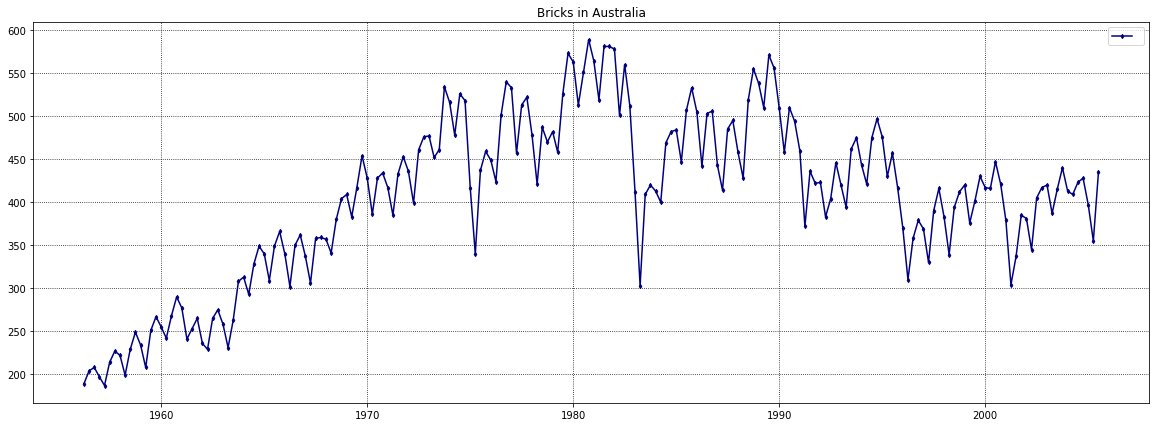

In [68]:
plotSeries(aus_production, title='Bricks in Australia')

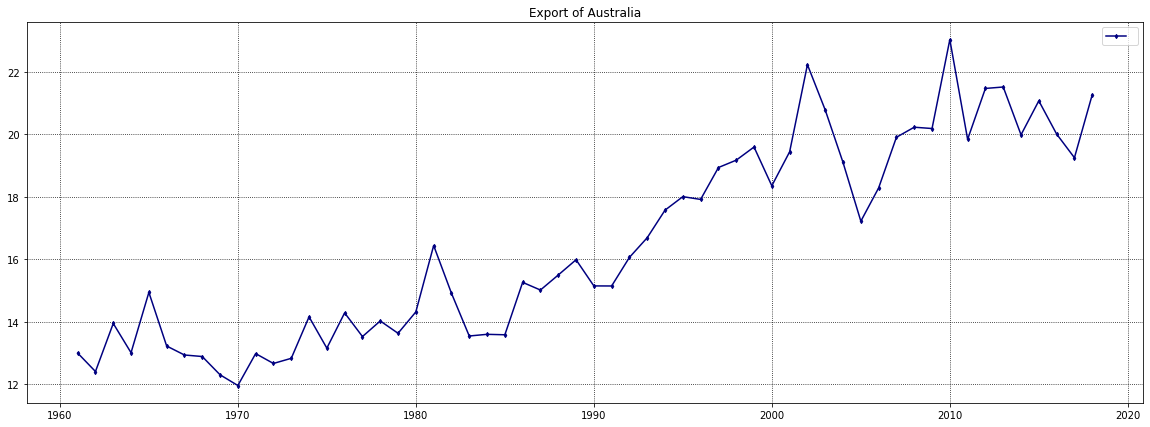

In [69]:
plotSeries(global_economy, title='Export of Australia')

### How can I plot these two series in one plot to have a chance to compare them?

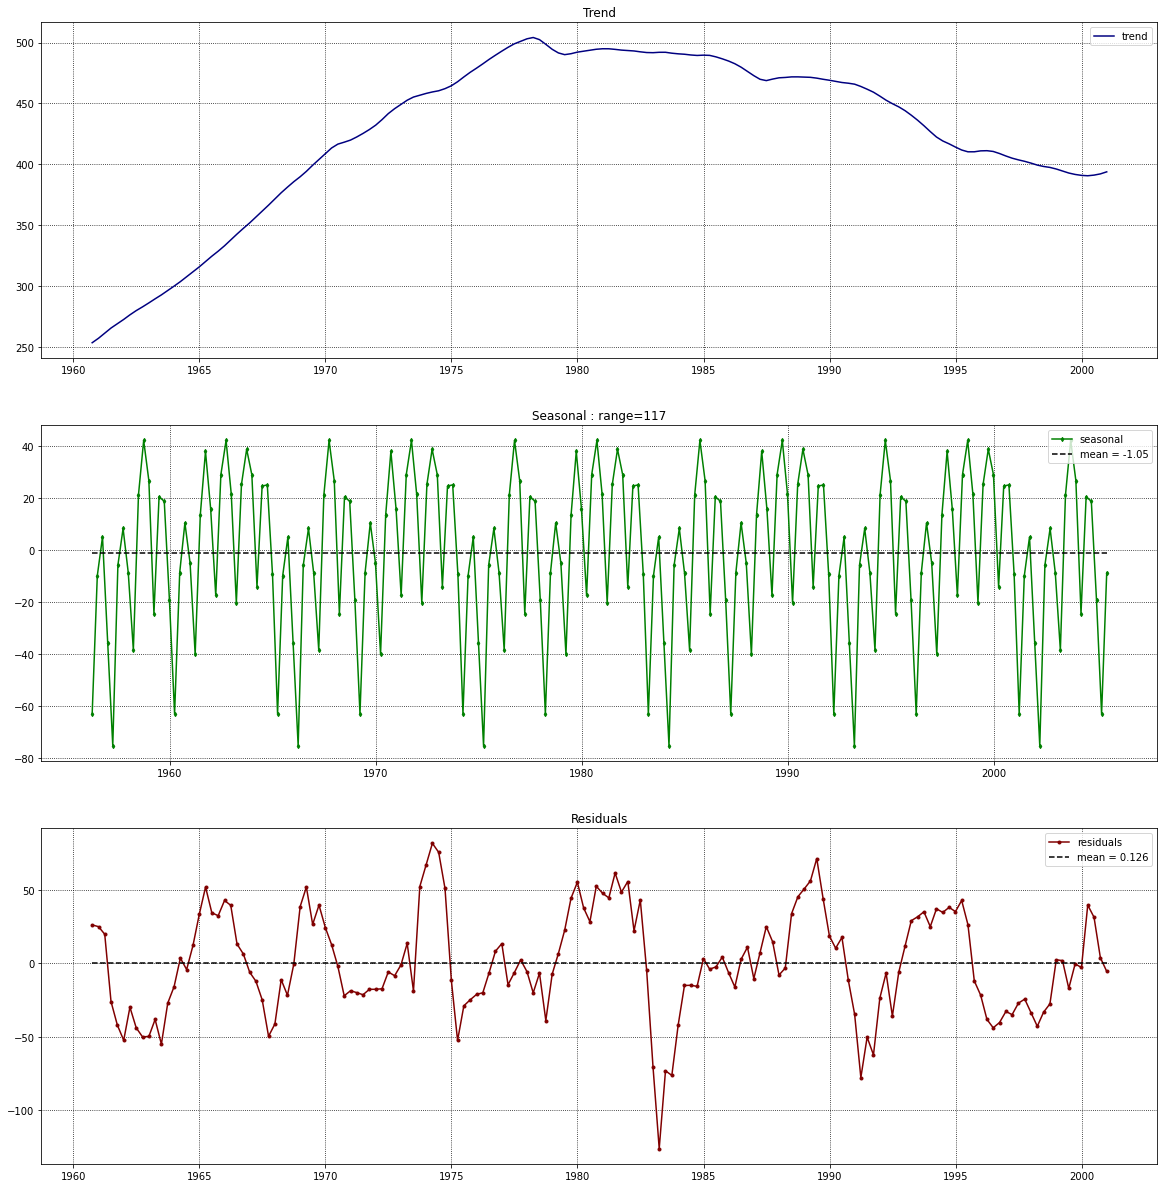

In [70]:
### Why period=36 is chosen?

decompose_bricks = seasonal_decompose(aus_production, period=36)
plotDecomposition(decompose_bricks)

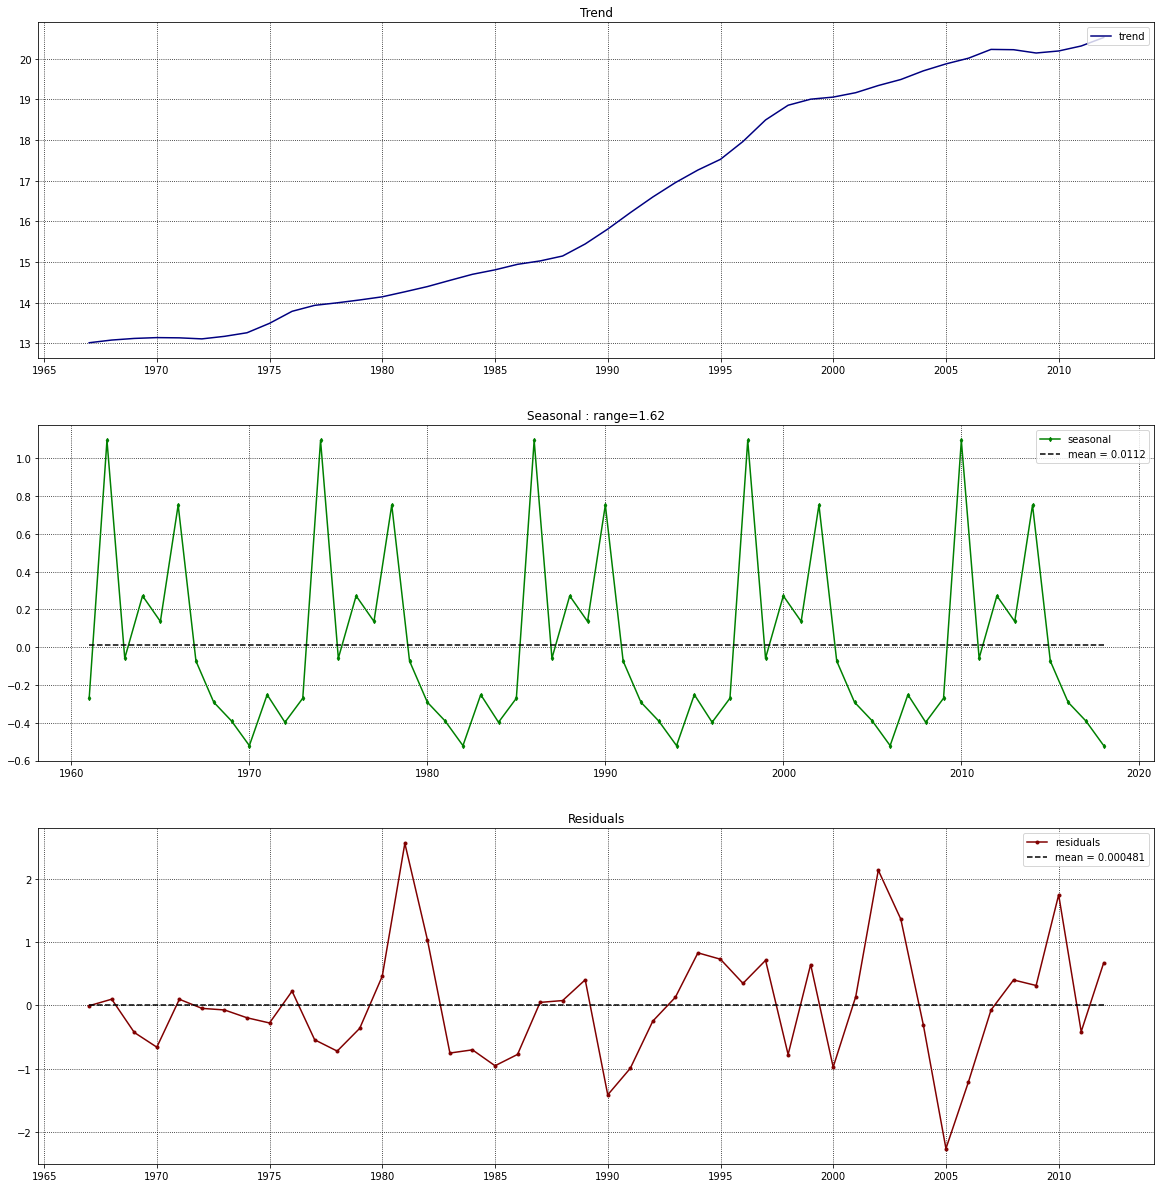

In [71]:
decompose_export = seasonal_decompose(global_economy, period=12)
plotDecomposition(decompose_export)

* Для global_economy (export): lag = 12
* Для aus_production (bricks): lag = 36  ### How did you get this number (36)?

## Specify

In [72]:
FORECAST_RANGE_export = 12
train_x_export, train_y_export = get_train_x_y(global_economy, forecast_range=FORECAST_RANGE_export)

Naive_export = TSNaive(train_x_export)
NaiveS_export = TSNaiveSeasonal(train_x_export, lag=12)


FORECAST_RANGE_bricks = 36
train_x_bricks, train_y_bricks = get_train_x_y(aus_production, forecast_range=FORECAST_RANGE_bricks)

Naive_bricks = TSNaive(train_x_bricks)
NaiveS_bricks = TSNaiveSeasonal(train_x_bricks, lag=36)

## Evaluate australian export

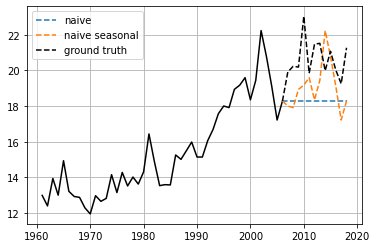

In [77]:
plt.plot(train_x_export, color='k')
plt.plot(Naive_export.forecast(periods=FORECAST_RANGE_export), color='C0', linestyle = '--', label='naive')
plt.plot(NaiveS_export.forecast(periods=FORECAST_RANGE_export), color='C1', linestyle = '--', label='naive seasonal')
plt.plot(train_y_export, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

In [78]:
lst = get_metrics(Naive_export.forecast(periods=FORECAST_RANGE_export), train_y_export, model='naive'), \
      get_metrics(NaiveS_export.forecast(periods=FORECAST_RANGE_export), train_y_export, model='naive seasonal')

pd.concat(lst)

,MAE,MSE,RMSE,MAPE
naive,2.182802,6.091706,2.468138,0.119375
naive seasonal,1.787600,4.505121,2.122527,0.095050


Здесь сезонная компонента менее выраженна, поэтому сложно сказать какой метод лучше. Судя по метрики, лучше работает naive seasonal

## Evaluate australian bricks

In [79]:
Naive_bricks

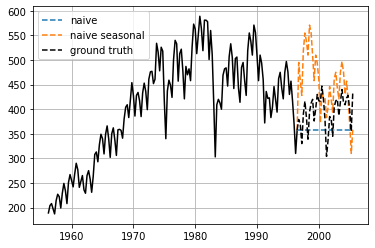

In [80]:
plt.plot(train_x_bricks, color='k')
plt.plot(Naive_bricks.forecast(periods=FORECAST_RANGE_bricks), color='C0', linestyle = '--', label='naive')
plt.plot(NaiveS_bricks.forecast(periods=FORECAST_RANGE_bricks), color='C1', linestyle = '--', label='naive seasonal')
plt.plot(train_y_bricks, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

In [81]:
lst = get_metrics(Naive_bricks.forecast(periods=FORECAST_RANGE_bricks), train_y_bricks, model='naive'), \
      get_metrics(NaiveS_bricks.forecast(periods=FORECAST_RANGE_bricks), train_y_bricks, model='naive seasonal')

pd.concat(lst)

,MAE,MSE,RMSE,MAPE
naive,43.324324,2395.972973,48.948677,0.121018
naive seasonal,69.378378,6935.918919,83.282164,0.147298


Как как здесь более ярко выраженная сезонность, то метод naive seasonal лучше описывет ground truth

    ### This conclusion contradicts with metrics. Please explain.

# 5. Produce forecasts for the 7 Victorian series

Produce forecasts for the 7 Victorian series in aus_livestock using SNAIVE(). Plot the resulting forecasts including the historical data. Is this a reasonable benchmark for these series?



# 6. Are the following statements true or false? Explain your answer.

1. Good forecast methods should have normally distributed residuals.
2. A model with small residuals will give good forecasts.
3. The best measure of forecast accuracy is MAPE.
4.If your model doesn’t forecast well, you should make it more complicated.
5. Always choose the model with the best forecast accuracy as measured on the test set.

1. True, В случае, если мы минимизируем функцию суммы квадрата ошибки, то при хорошем прогнозе остатки действительно будут нормально распределены. Если минимизируется фунция MAE, то ошибки должны принять распределение Лапласа

        ### Here is a wrong causal relationship

2. False. потому что можно представить случай, в котором ВСЕ остатки будут > 0 но меньше E, тогда среднее != 0  ===> остатки смещены и прогноз может быть учучшен отнятием CONST_value.

        ### A matter for discussion... As for me that is a question of comparison between different models. But yes - we should analyze the whole picture of distribution of residuals.

3. False. No metric is the best. In addition, MAPE has many disadvantages.

        ### Which for example? Can we cope with them? How?
        https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

4. False / True. We can use new Scale or take another simple model for forecasting + do more research about residuals + больше разобраться в доменной области.

        ### Definitely yes. Starting with the the question of complicity of the model we can think at first about under/over- fitting.

5. True. Когда мы выбрали метрику, которая лучшим образом решает нашу бизнес задачу, тогда можно и искать модель, которая дает лучший скор.

        ### Imagine that we choose RMSE, please explain your statement for Anscombe's quartet
(https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

# 7. For your retail time series (from Exercise 8 in Section 2.10):

Тут хотел бы обсудить train test split для timeseries рядов

        ### Let's do it :)

# 11. We will use the Bricks data from aus_production (Australian quarterly clay brick production 1956–2005) for this exercise.

1. Use an STL decomposition to calculate the trend-cycle and seasonal indices. (Experiment with having fixed or changing seasonality.)
2. Compute and plot the seasonally adjusted data.
3. Use a naïve method to produce forecasts of the seasonally adjusted data.
4. Use decomposition_model() to reseasonalise the results, giving forecasts for the original data.
5. Do the residuals look uncorrelated?
6. Repeat with a robust STL decomposition. Does it make much difference?
7. Compare forecasts from decomposition_model() with those from SNAIVE(), using a test set comprising the last 2 years of data. Which is better?

In [82]:
from statsmodels.tsa.seasonal import STL

In [83]:
bricks = aus_production.copy()
bricks

1956-03-31    189.0
1956-06-30    204.0
1956-09-30    208.0
1956-12-31    197.0
1957-03-31    187.0
              ...  
2004-06-30    423.0
2004-09-30    428.0
2004-12-31    397.0
2005-03-31    355.0
2005-06-30    435.0
Freq: Q-DEC, Name: Bricks, Length: 198, dtype: float64

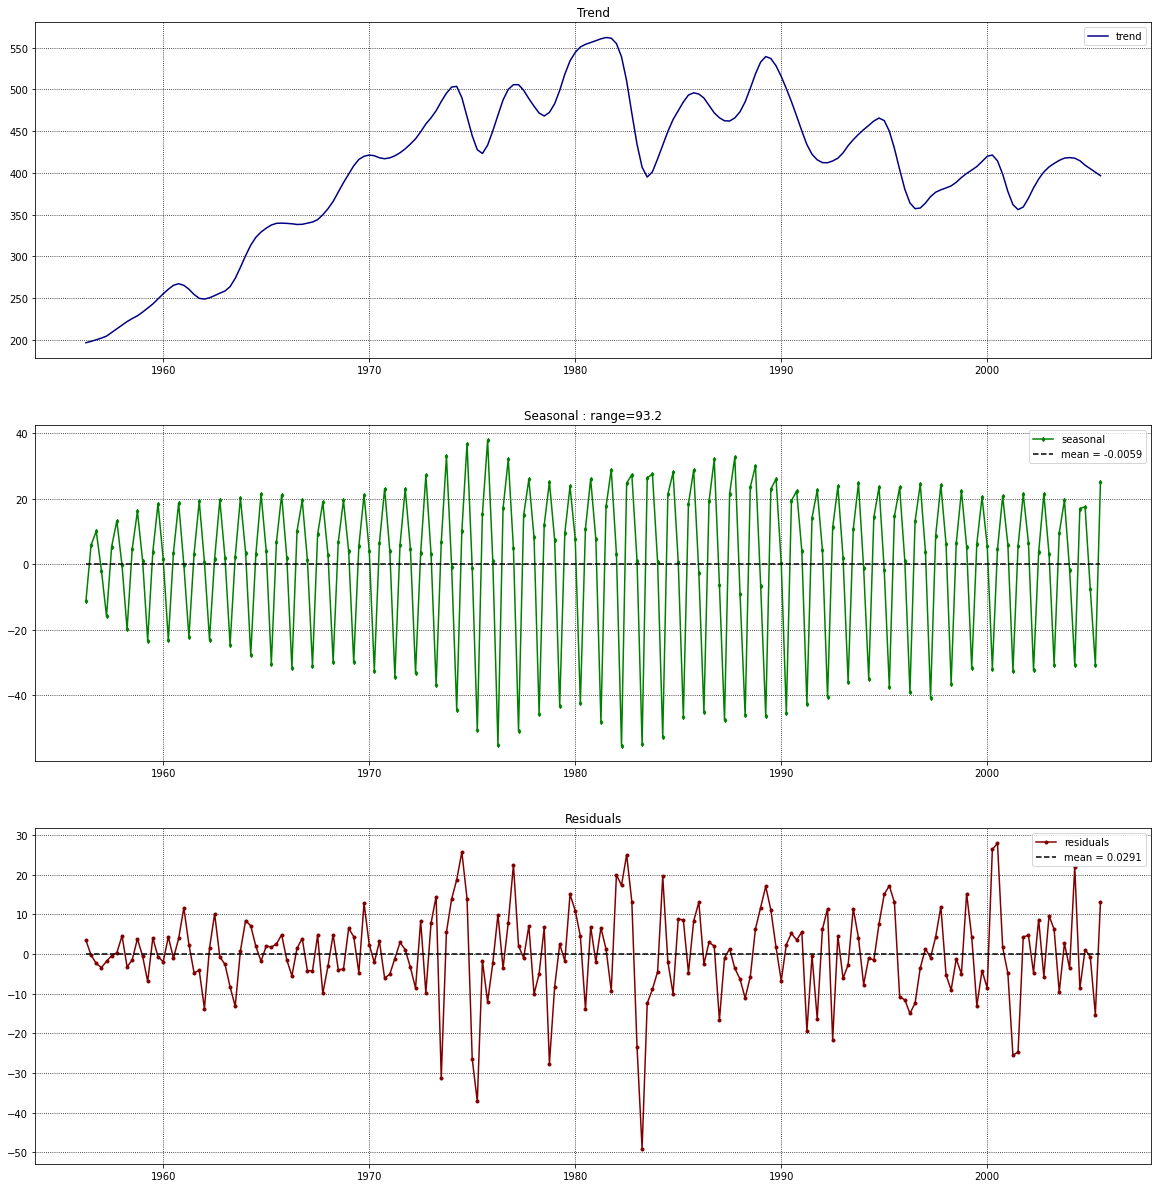

In [84]:
res = STL(bricks, period=4).fit()
plotDecomposition(res)

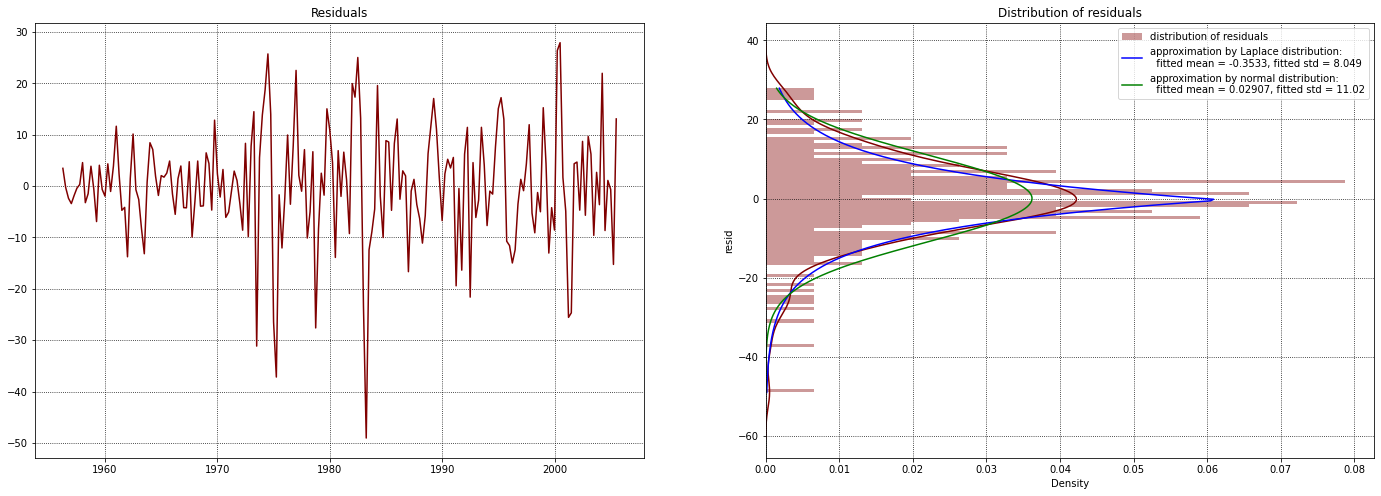

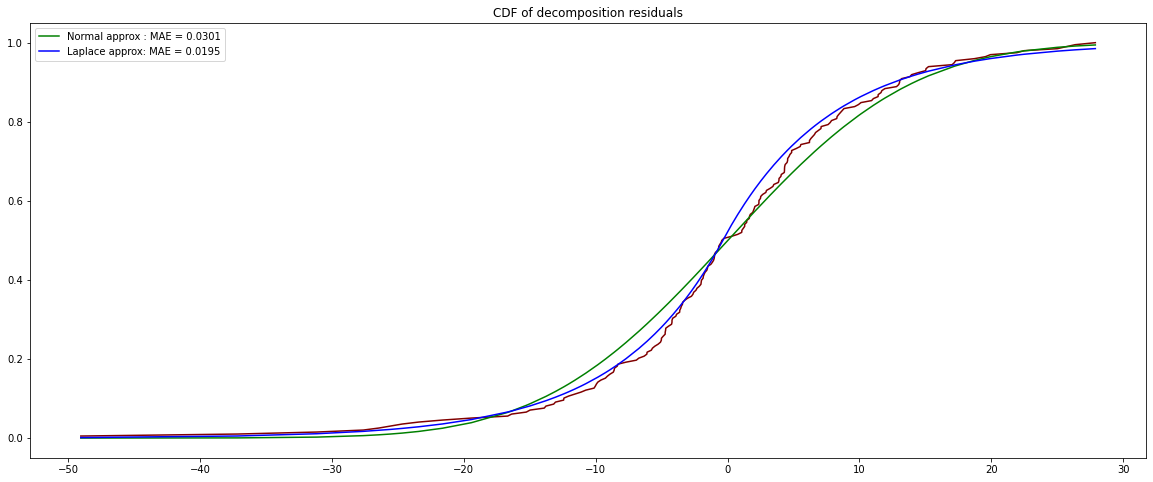

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -8.316920158553968
p-value: 3.6596447983604733e-13
The process is stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.010254042408589828
p-value = 0.1
The process is stationary by KPSS.



In [85]:
getResidAnalytics(res.resid)

In [86]:
naive = TSNaive(res.seasonal)

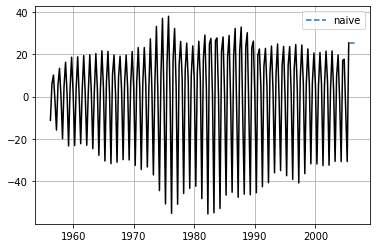

In [87]:
plt.plot(res.seasonal, color='k')
plt.plot(naive.forecast(periods=4), color='C0', linestyle = '--', label='naive')
plt.legend()
plt.grid()

Если в условии ничего не напутали, и нам действилельно нужно использовать naive модель для предсказания, то можно уже представить, как будут вести себя остатки: mean = mean(seasonal) / 2, то есть они будут смещены

## Naive

In [90]:
### Why 16? Can we treat this parameter as a hyperparameter?

FORECAST_RANGE = 16

In [91]:
seasonal = res.seasonal
trend = res.trend

In [92]:
train_seasonal_x, train_seasonal_y = get_train_x_y(seasonal, forecast_range=FORECAST_RANGE)
train_trend_x, train_trend_y = get_train_x_y(trend,forecast_range=FORECAST_RANGE)

train_x, train_y = get_train_x_y(bricks, forecast_range=FORECAST_RANGE)

Пусть мы предсказываем только seasonal компоненту, тогда 

In [93]:
naive = TSNaive(train_seasonal_x)

In [94]:
pred = naive.forecast(periods=FORECAST_RANGE) + train_trend_y

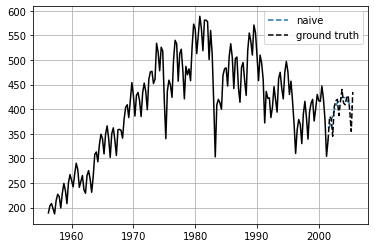

In [95]:
plt.plot(train_x, color='k')
plt.plot(pred, color='C0', linestyle = '--', label='naive')
### Strictly speaking that is a SEASONAL naive
### And the red color is better in my opinin

plt.plot(train_y, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

In [100]:
naive_residuals = train_y - pred

In [102]:
naive_residuals.mean()

-4.600283364733317

In [103]:
### I recommend you print sentences
### Compare with your 'statement' above

print(f"The residuals are shifted by {naive_residuals.mean():.4g} [units], ", end="")
print(f"while their std = {naive_residuals.std():.4g} [units].")
ratio = naive_residuals.mean()/naive_residuals.std()
print(f"In other words the shift of mean value for residuals is {ratio:.2%} of std. ")

The residuals are shifted by -4.6 [units], while their std = 22.81 [units].
In other words the shift of mean value for residuals is -20.17% of std. 


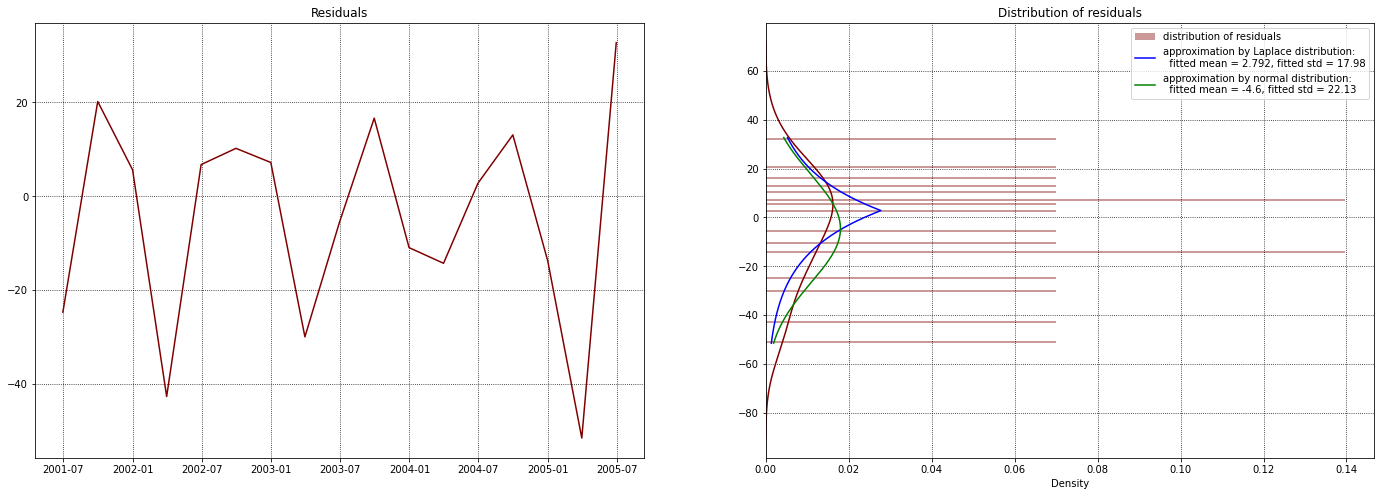

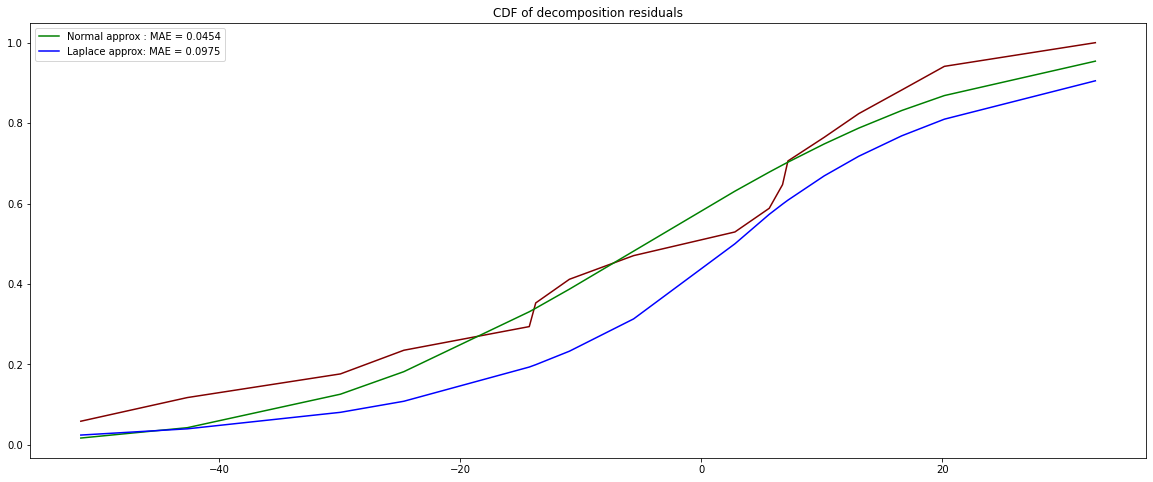

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -3.247396461862267
p-value: 0.01739996319102859
The process is stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.18973980654357642
p-value = 0.1
The process is stationary by KPSS.



In [104]:
getResidAnalytics(naive_residuals)

Начальное представление об остатках было ошибочным. :( интересно посмотреть, как будет себя вести naive seasonal

        ### What is the error?

## Naive seasonal

In [105]:
FORECAST_RANGE = 16

In [106]:
seasonal = res.seasonal
trend = res.trend

In [107]:
train_seasonal_x, train_seasonal_y = get_train_x_y(seasonal, forecast_range=FORECAST_RANGE)
train_trend_x, train_trend_y = get_train_x_y(trend,forecast_range=FORECAST_RANGE)

train_x, train_y = get_train_x_y(bricks, forecast_range=FORECAST_RANGE)

Пусть мы предсказываем только seasonal компоненту, тогда 

In [108]:
naive = TSNaiveSeasonal(train_seasonal_x, lag=4)

In [109]:
pred = naive.forecast(periods=FORECAST_RANGE) + train_trend_y

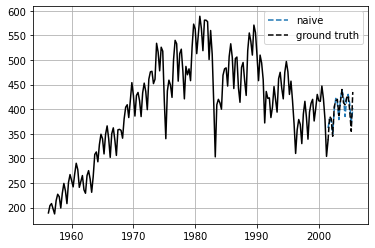

In [110]:
plt.plot(train_x, color='k')
plt.plot(pred, color='C0', linestyle = '--', label='naive')
plt.plot(train_y, color='k', linestyle = '--' , label='ground truth')

plt.legend()
plt.grid()

In [111]:
naive_residuals = train_y - pred

In [112]:
naive_residuals.mean()

### We should compare this value with std

0.6854995360065559

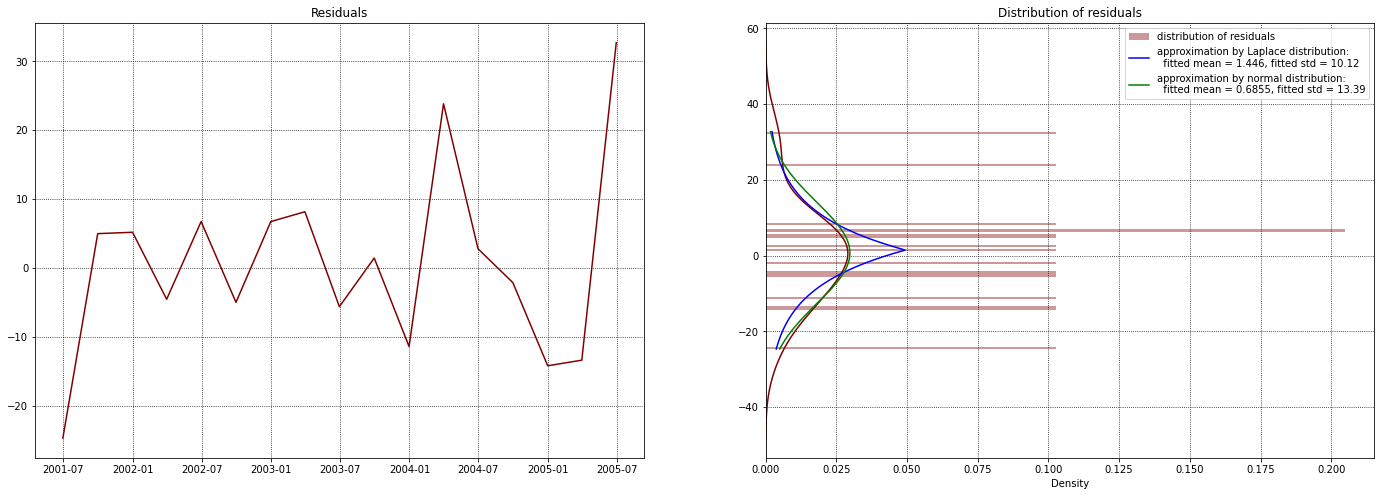

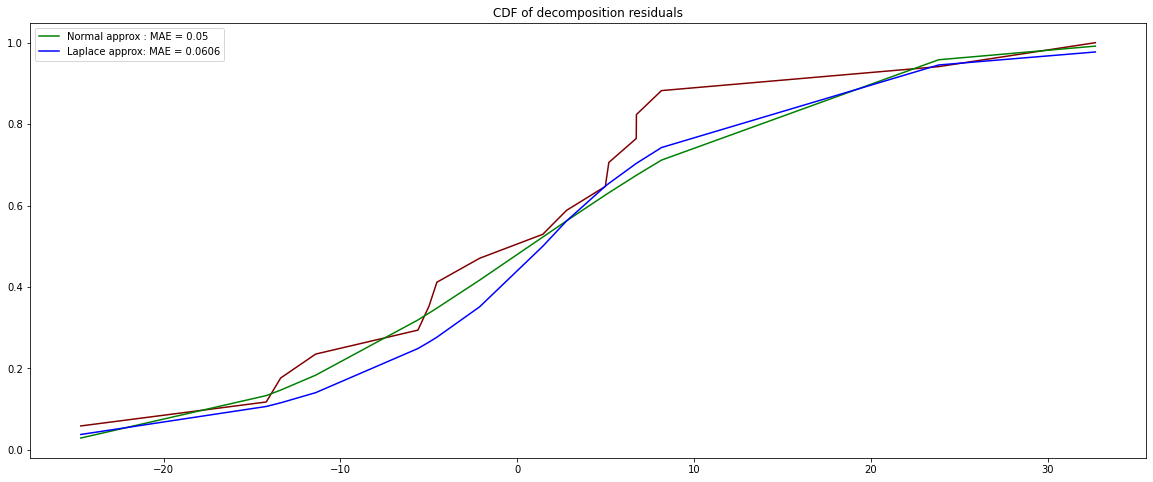

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -3.238089740455275
p-value: 0.0178830844265088
The process is stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.1736852638123598
p-value = 0.1
The process is stationary by KPSS.



In [113]:
getResidAnalytics(naive_residuals)

Воот, теперь модель улавливает сеазональную компоненту, и mean ошибка стала близка к 0.  

В прошлом варианте сеазональная компонента = const, и если мы сделаем FORECAST_RANGE больше, то mean(residuals) == CONST